### Ideas
* Maak nieuwe colomn met merk namen
* 

In [1]:
from collections import Counter
import re

import json
import math
import numpy as np
import pandas as pd
import random
from collections import defaultdict
import itertools

from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix

import matplotlib.pyplot as plt
# import seaborn as sns 

In [368]:
def create_df(data):
    '''
    Creates a pandas dataframe from JSON input with high-level info
    '''
    raw_df = pd.json_normalize(data).transpose()
    df = pd.DataFrame(columns = ['shop', 'url', 'modelID', 'title', 'features'])
    for i in range(len(raw_df)):
        for j in range(len(raw_df[0][i])):
            row = [raw_df[0][i][j]['shop'], 
                    raw_df[0][i][j]['url'], 
                    raw_df[0][i][j]['modelID'], 
                    raw_df[0][i][j]['title'], 
                    raw_df[0][i][j]['featuresMap']]
            df.loc[len(df.index)] = row
    return df

def normalize_list(textList):
    '''
    String normalisation: all lower case, inch and hertz expressions, remove punctuations
    '''
    normalized_titles = []
    
    for row in textList:
        row = row.lower()
        row = row.replace('"','inch') 
        row = row.replace('”','inch') 
        row = row.replace("'",'inch') 
#         row = row.replace('in','inch')
        row = row.replace(' inch','inch')
        row = row.replace('-inch','inch')
        row = row.replace('inches','inch')
        
        row = row.replace('hertz','hz')
        row = row.replace('-hz','hz')
        row = row.replace(' hz','hz')

        #remove punctuations
        row = row.replace('.','')
        row = row.replace('-','')
        row = row.replace('(','')
        row = row.replace(')','')
        row = row.replace('[','')
        row = row.replace(']','')
        row = row.replace(':','')
        row = row.replace('/','')
        row = row.replace(',','')
        row = row.replace('°','')
        row = row.replace('º','')
        row = row.replace('>','')
        row = row.replace('<','')

        normalized_titles.append(row)

    return normalized_titles

def normalize_dictionary(textDict):
    '''
    String normalisation: all lower case, inch and hertz expressions, remove punctuations
    '''
    normalized_dict = {}

    for key,val in textDict.items():
        val = val.lower()
        val = val.replace('"','inch')
        val = val.replace('inches','inch')
        val = val.replace('hertz','hz')

        #remove punctuations
        val = val.replace('.','')
        val = val.replace('-','')
        val = val.replace('(','')
        val = val.replace(')','')
        val = val.replace('[','')
        val = val.replace(']','')
        val = val.replace(':','')
        val = val.replace('/','')
        val = val.replace(',','')
        val = val.replace('°','')
        val = val.replace('º','')
        val = val.replace('>','')
        val = val.replace('<','')
        
        # remove strange signs like: 
#         val = val.replace('','')

        normalized_dict[key] = val
    
    return normalized_dict

def is_model_word(input_string):
    has_letters = any(char.isalpha() for char in input_string)
    has_numbers = any(char.isdigit() for char in input_string)

    return has_letters and has_numbers

def product_representation(titles,TV_brands):
    '''
    Creates a list of product representations
    Includes model words from the titles, and TV brand names in the title, and model words in the values
    '''
    representations = []

    for TV in range(len(titles)):
        TV_rep = []
        title_list = titles[TV].split()
        for string in title_list:
            if is_model_word(string):
                TV_rep.append(string)
            if string in TV_brands:
                TV_rep.append(string)
               
        representations.append(TV_rep)
    
    return representations

def product_representation_2(titles,TV_brands,features):
    '''
    Creates a list of product representations
    Includes model words from the titles, and TV brand names in the title, and model words in the values
    '''
    representations = []

    for TV in range(len(titles)):
        TV_rep = []
        title_list = titles[TV].split()
        for string in title_list:
            if is_model_word(string):
                TV_rep.append(string)
            if string in TV_brands:
                TV_rep.append(string)
        for key,val in features[TV].items():
            val_list = val.split()
            for word in val_list:
                if is_model_word(word):
                    TV_rep.append(word)        
        representations.append(TV_rep)
    
    return representations

def binary_matrix(product_representations):
    '''
    Create binary matrix for product representations
    Entries are binary vectors for each TV with 1 if token present, 0 else
    Returns binary numpy matrix and the list of tokens in correct order
    '''
    #use unique tokens
    flat_list = [item for sublist in product_representations for item in sublist]
    tokens = list(set(flat_list))
    
    #rows are elements of token set, columns are TVs
    binary_matrix = np.zeros((len(tokens),len(product_representations)), dtype=int)
    for tv in range(len(product_representations)):
        for token in range(len(tokens)):
            if tokens[token] in product_representations[tv]:
                binary_matrix[token][tv] = 1

    return binary_matrix, tokens

def find_next_prime(number):
    def is_prime(num):
        if num < 2:
            return False
        for i in range(2, int(num**0.5) + 1):
            if num % i == 0:
                return False
        return True
    next_number = number + 1
    while not is_prime(next_number):
        next_number += 1
    return next_number    
        
def randomCoefficients(numHashes):
    randList = []
    for i in range(numHashes):
        randIndex = random.randint(0,numHashes)
        while randIndex in randList:
            randIndex = random.randint(0,numHashes)
        randList.append(randIndex)
    return randList

def minhash_2(numHashFunc, binary_matrix):
    '''
    Performs min-hashing using the implementation in the lecture
    The hash functions are of the form ax + b % P, where x is the input,
    a and b random coefficients, and P is the first prime number larger than
    the number of tokens
    '''
    #Create numHashFunc random (and unique) hash functions
    P = find_next_prime(binary_matrix.shape[0])
    a = randomCoefficients(numHashFunc)
    b = randomCoefficients(numHashFunc)
    hashFunc = lambda a,b,P,x: (a * x + b) % P
    hash_values = np.zeros(numHashFunc)
    
    #Initialize M with infinity
#     M = np.full((numHashFunc,binary_matrix.shape[1]), np.inf)
    M = pd.DataFrame(np.inf, index= range(numHashFunc),columns = range(binary_matrix.shape[1]))    

    #iterate over ROWS of TVs
    for row_idx, row in enumerate(binary_matrix):
        for hash_idx in range(numHashFunc):
            hash_values[hash_idx] = hashFunc(a[hash_idx],b[hash_idx],P,row_idx)
        for col_idx, col in enumerate(binary_matrix.T):
            if col[row_idx] == 1:
                for idx in range(numHashFunc):
                    if hash_values[idx] < M[col_idx][idx]:
                        M[col_idx][idx] = hash_values[idx]
    
    return M

def minhash(numHashFunc, binary_matrix):
    '''
    Performs min-hashing using the implementation in the lecture
    The hash functions are of the form ax + b % P, where x is the input,
    a and b random coefficients, and P is the first prime number larger than
    the number of tokens
    '''
    #Create numHashFunc random (and unique) hash functions
    P = find_next_prime(binary_matrix.shape[0])
    a = randomCoefficients(numHashFunc)
    b = randomCoefficients(numHashFunc)
    hashFunc = lambda a,b,P,x: (a * x + b) % P
    hash_values = np.zeros(numHashFunc)
    
    #Initialize M with infinity
    M = np.full((numHashFunc,binary_matrix.shape[1]), np.inf)

    #iterate over ROWS of TVs
    for row_idx, row in enumerate(binary_matrix):
        for hash_idx in range(numHashFunc):
            hash_values[hash_idx] = hashFunc(a[hash_idx],b[hash_idx],P,row_idx)
        for col_idx, col in enumerate(binary_matrix.T):
            if col[row_idx] == 1:
                for idx in range(numHashFunc):
                    if hash_values[idx] < M[idx,col_idx]:
                        M[idx,col_idx] = hash_values[idx]
    
    return M

def initialize_hash_bucket(bands, nBuckets):
    '''
    Initializes the hash matrix, with nBuckets empty lists for each band
    '''
    hash_buckets = []
    for band in range(bands):
        hash_buckets.append([[] for i in range(nBuckets)])
    return hash_buckets

def get_b(numSig, threshold):
        """
        Calculates the number of bands needed such that approximately it holds that
        (1/b)^(1/r) = threshold and b*r = numSig
        """
        n = numSig
        t = threshold
        def get_bandwidth(n, t):
            best = n, 1
            minerr  = float("inf")
            for r in range(1, n + 1):
                try:
                    b = 1. / (t ** r)
                except:             # Divide by zero, your signature is huge
                    return best
                err = abs(n - (b * r))
                if err < minerr:
                    best = r
                    minerr = err
            return best
        r = get_bandwidth(n, t)
        b = int(n / r)
        return b

def LSH(signature_matrix, thres):
    # Create brand_pairs (only select pairs that have the same brand, otherwise never duplicates)
#     brand_pairs = brand_list
    '''
    Perform LSH on the signature matrix, with number of bands b,
    rows per band r, and threshold t.
    '''
    # Take nBuckets very large such that columns only hashed to same bucket when identical
    nBuckets = find_next_prime(100*signature_matrix.shape[0])
    nBands = get_b(signature_matrix.shape[0],thres)
    
    hash_buckets = initialize_hash_bucket(nBands, nBuckets)
    numHashFunc, numTV = signature_matrix.shape
    candidates = set()
    candidate_similarity = []
    rowsPerBand = math.floor(numHashFunc/nBands)
    rowsLeft = numHashFunc % nBands

    for b in range(nBands):
        #put rest of the rows in the final band
        if b == nBands - 1:
            band = signature_matrix[b*rowsPerBand:(b+1)*rowsPerBand + rowsLeft,:]
            # As hash function, take a random linear transformation of the signatures and take modulo of nBuckets
            hash_function = np.random.randint(1, numHashFunc, size = rowsPerBand + rowsLeft)
        else:
            band = signature_matrix[b*rowsPerBand:(b+1)*rowsPerBand,:]
            hash_function = np.random.randint(1, numHashFunc, size = rowsPerBand)
        for col in range(numTV):
            key = int(hash_function.dot(band[:,col]) % nBuckets)
            hash_buckets[b][key].append(col)

        #for band b, check each bucket for duplicates
        for bucket in hash_buckets[b]:
            if len(bucket) > 1:
                for pair in itertools.combinations(bucket, 2):
                    if pair not in candidates:
                        A = signature_matrix[:,pair[0]]
                        B = signature_matrix[:,pair[1]]
                        similarity = jaccard_score(A,B,average='macro')
                        #if similarity > thres, add to candidates  
                        if similarity >= thres:
                            candidates.add(pair)
                            candidate_similarity.append(similarity)

    return list(candidates), list(candidate_similarity)        

def LSH_2(signature_matrix, thres):
    # Where to put the selection combinations set such that the function is most efficient? Since
    # we want the LSH only to consider the pre_selected pairs and only try to create candidates
    # that are not in this list. Otherwise way more computation
    
    # Create brand_pairs (only select pairs that have the same brand, otherwise never duplicates)
#     selection_list = brand_shop_avaiable_modelID_combinations(df)
    '''
    Perform LSH on the signature matrix, with number of bands b,
    rows per band r, and threshold t.
    '''
    # Take nBuckets very large such that columns only hashed to same bucket when identical
    nBuckets = find_next_prime(100*signature_matrix.shape[0])
    nBands = get_b(signature_matrix.shape[0],thres)
    
    print('nBands :', nBands)

    hash_buckets = initialize_hash_bucket(nBands, nBuckets)
    numHashFunc, numTV = signature_matrix.shape
    candidates = set()
    candidate_similarity = []
    rowsPerBand = math.floor(numHashFunc/nBands)
    rowsLeft = numHashFunc % nBands

    for b in range(nBands):
        #put rest of the rows in the final band
        if b == nBands - 1:
            band = signature_matrix[b*rowsPerBand:(b+1)*rowsPerBand + rowsLeft,:]
            # As hash function, take a random linear transformation of the signatures and take modulo of nBuckets
            hash_function = np.random.randint(1, numHashFunc, size = rowsPerBand + rowsLeft)
        else:
            band = signature_matrix[b*rowsPerBand:(b+1)*rowsPerBand,:]
            hash_function = np.random.randint(1, numHashFunc, size = rowsPerBand)
        for col in range(numTV):
            key = int(hash_function.dot(band[:,col]) % nBuckets)
            hash_buckets[b][key].append(col)

        #for band b, check each bucket for duplicates
        for bucket in hash_buckets[b]:
            if len(bucket) > 1:
                for pair in itertools.combinations(bucket, 2):
                    if pair not in candidates :                               # and pair in selection_list:
                        A = signature_matrix[:,pair[0]]
                        B = signature_matrix[:,pair[1]]
                        similarity = jaccard_score(A,B,average='macro')
                        
                        #if similarity > thres, add to candidates  
                        if similarity >= thres:
                            candidates.add(pair)
                            candidate_similarity.append(similarity)
                            if len(candidates) % 100 == 0:
                                print(f'# Candidates: {len(candidates)}...')

    return list(candidates), list(candidate_similarity)        
 

#def similarity(candidate_pairs, bin_matrix):
#    for pair in candidate_pairs:
#        TV_1 = bin_matrix[:,pair[0]]
#        TV_2 = bin_matrix[:,pair[1]]
#        similarity = np.linalg.norm(TV_1-TV_2)
#        print(similarity)

def main():
    print("Loading data...")
    
#     with open("D:/Studie/23-24/Blok 2/Computer Science/Personal Assignment/TVs-all-merged (1)/TVs-all-merged.json", 'r') as read_file:
#         data = json.load(read_file)
    with open("F:/Documenten/1. Erasmus Rotterdam/Master Econometrics/Q2/Computer Science for Business Analytics/Assignment/TVs-all-merged/TVs-all-merged.json", 'r') as read_file:
        data = json.load(read_file)
    read_file.close()
    df = create_df(data)

    #toy data
    
    #TV1 = "philips 1080p 530hz 30inch"
    #TV1 = "samsung 4k 100hz 50inch 1080p 30inch 530hz philips"
    #TV2 = "samsung 4k 100hz 50inch 1080p 30inch 530hz"
    #data = {'title': [TV1,TV2]}
    #df = pd.DataFrame(data)
    
    print("Creating product representations...")
    
    #Product representations are model words in the title, model words in the values, and brands in the titles
    df['title'] = normalize_list(df['title'])
    TV_brands_1 = ["Bang & Olufsen","Continental Edison","Denver","Edenwood","Grundig","Haier","Hisense","Hitachi","HKC","Huawei","Insignia","JVC","LeEco","LG","Loewe","Medion","Metz","Motorola","OK.","OnePlus","Panasonic","Philips","RCA","Samsung","Sceptre","Sharp","Skyworth","Sony","TCL","Telefunken","Thomson","Toshiba","Vestel","Vizio","Xiaomi","Nokia","Engel","Nevir","TD Systems","Hyundai","Strong","Realme","Oppo","Metz Blue","Asus","Amazon","Cecotec","Nilait","Daewoo","insignia","nec","supersonic","viewsonic","Element","Sylvania","Proscan","Onn","Vankyo","Blaupunkt","Coby","Kogan","RCA","Polaroid","Westinghouse","Seiki","Insignia","Funai","Sansui","Dynex","naxa"]
    TV_brands_2 = ['Philips', 'Samsung', 'Sharp', 'Toshiba', 'Hisense', 'Sony', 'LG', 'RCA', 'Panasonic', 'VIZIO', 'Naxa', 'Coby', 'Vizio', 'Avue', 'Insignia', 'SunBriteTV', 'Magnavox', 'Sanyo', 'JVC', 'Haier', 'Venturer', 'Westinghouse', 'Sansui', 'Pyle', 'NEC', 'Sceptre', 'ViewSonic', 'Mitsubishi', 'SuperSonic', 'Curtisyoung', 'Vizio', 'TCL', 'Sansui', 'Seiki', 'Dynex']
    TV_brands = normalize_list(list(set(TV_brands_1) | set(TV_brands_2)))
    df['features'] = df['features'].apply(lambda x: normalize_dictionary(x))

    product_representations = product_representation(df['title'],TV_brands,df['features'])

    #print(product_representations)

    print("Creating binary matrix...")

    bin_matrix, tokens = binary_matrix(product_representations)
    
    print("Min-hashing...")

    signatures = minhash(100,bin_matrix)

    print("LSH...")

    candidate_pairs = LSH(signatures, 0.3)

    print(candidate_pairs)

In [7]:
def title_cleaner(data_frame, data_frame_and_title):
    textList = data_frame_and_title
    data_frame['title_cleaned'] = 'chexck'
    
    for row in range(len(textList)):
        input_string = textList[row]
        
        # Convert to lowercase
        input_string = input_string.lower()

        # Remove specific words
        words_to_remove = ['newegg.com', 'best', 'buy', 'refurbished', 'diagonal', 'diag.']
        for word in words_to_remove:
            input_string = input_string.replace(word, '')
        def round_numbers_in_string(input_string):
            def custom_round(match):
                return str(round(float(match.group(0))))

            pattern = r'\b\d+\.\d+\b|\b\d+\b'
            rounded_string = re.sub(pattern, custom_round, input_string)
            
            # Remove parts of the string that only contain letters or only contain numeric values
            rounded_string = ' '.join(word for word in rounded_string.split() if not word.isalpha() and not word.isdigit())
            
            # Ensure only unique values
            unique_words = set(rounded_string.split())
            unique_result = ' '.join(unique_words)
            
            return unique_result

        rounded_result = round_numbers_in_string(input_string)
        data_frame['title_cleaned'][row] = rounded_result
        
    return 

# title_cleaner(df, df['title'])

In [363]:
def import_data():
    print("Loading data...")

    #     with open("D:/Studie/23-24/Blok 2/Computer Science/Personal Assignment/TVs-all-merged (1)/TVs-all-merged.json", 'r') as read_file:
    #         data = json.load(read_file)
    with open("F:/Documenten/1. Erasmus Rotterdam/Master Econometrics/Q2/Computer Science for Business Analytics/Assignment/TVs-all-merged/TVs-all-merged.json", 'r') as read_file:
        data = json.load(read_file)
    read_file.close()
    df = create_df(data)
    print(df['title'][1622])

    #toy data

    #TV1 = "philips 1080p 530hz 30inch"
    #TV1 = "samsung 4k 100hz 50inch 1080p 30inch 530hz philips"
    #TV2 = "samsung 4k 100hz 50inch 1080p 30inch 530hz"
    #data = {'title': [TV1,TV2]}
    #df = pd.DataFrame(data)

    print("Creating product representations...")
    # First step title cleaner that removes useless stuff and creates new title column "title_cleaned"
    title_cleaner(df, df['title'])
    
    # Second step normalizer to further clean data to for LSH
    df['title_cleaned'] = normalize_list(df['title_cleaned'])
    
    # Also normalize the original title
    df['title'] = normalize_list(df['title'])

    # Clean title_cleaned again for only words or only nummeric values
    title_cleaner(df, df['title_cleaned'])

    
    #Product representations are model words in the title, model words in the values, and brands in the titles
#     df['title'] = normalize_list(df['title'])
    TV_brands_1 = ["Bang & Olufsen","Continental Edison","Denver","Edenwood","Grundig","Haier","Hisense","Hitachi","HKC","Huawei","Insignia","JVC","LeEco","LG","Loewe","Medion","Metz","Motorola","OK.","OnePlus","Panasonic","Philips","RCA","Samsung","Sceptre","Sharp","Skyworth","Sony","TCL","Telefunken","Thomson","Toshiba","Vestel","Vizio","Xiaomi","Nokia","Engel","Nevir","TD Systems","Hyundai","Strong","Realme","Oppo","Metz Blue","Asus","Amazon","Cecotec","Nilait","Daewoo","insignia","nec","supersonic","viewsonic","Element","Sylvania","Proscan","Onn","Vankyo","Blaupunkt","Coby","Kogan","RCA","Polaroid","Westinghouse","Seiki","Insignia","Funai","Sansui","Dynex","naxa"]
    TV_brands_2 = ['Philips', 'Samsung', 'Sharp', 'Toshiba', 'Hisense', 'Sony', 'LG', 'RCA', 'Panasonic', 'VIZIO', 'Naxa', 'Coby', 'Vizio', 'Avue', 'Insignia', 'SunBriteTV', 'Magnavox', 'Sanyo', 'JVC', 'Haier', 'Venturer', 'Westinghouse', 'Sansui', 'Pyle', 'NEC', 'Sceptre', 'ViewSonic', 'Mitsubishi', 'SuperSonic', 'Curtisyoung', 'Vizio', 'TCL', 'Sansui', 'Seiki', 'Dynex','Optoma','compaq','Upstar', 'hannspree', 'craig','contex','affinity','hiteker','azend group','epson','hp','elo','hello kitty','gpx','viore','sigmac','vizio']
    TV_brands = normalize_list(list(set(TV_brands_1) | set(TV_brands_2)))
    df['features'] = df['features'].apply(lambda x: normalize_dictionary(x))

    # Also make sure that model ID's are in similar formats for testing purpose
    df['modelID'] = normalize_list(df['modelID'])
    
    return df

# Create data frame
# df = import_data()

def get_LSH(threshold, df_in, number_of_hash_buckets):
    # Use reduced_combinations_list to input a preselected list so the LSH can be used more efficiently.
    # Implement this list in the LSH function
    TV_brands = brand_list()
    
    product_representations = product_representation(df_in['title_cleaned'],TV_brands)  

    #print(product_representations)

    print("Creating binary matrix...")

    bin_matrix, tokens = binary_matrix(product_representations)

    print("Min-hashing...")

    signatures = minhash(number_of_hash_buckets,bin_matrix)

    print("LSH...")

    candidate_pairs = LSH_2(signatures, threshold)

    return candidate_pairs



In [327]:
get_LSH(0.95, df_test, 100)

Creating binary matrix...
Min-hashing...
LSH...
nBands : 3


([(512, 528),
  (342, 544),
  (92, 122),
  (117, 258),
  (150, 304),
  (284, 304),
  (213, 503),
  (240, 523),
  (566, 596),
  (103, 600),
  (299, 481),
  (180, 280),
  (63, 550),
  (43, 201),
  (249, 303),
  (180, 579),
  (104, 242),
  (62, 301),
  (472, 543),
  (254, 534),
  (154, 386),
  (320, 540),
  (164, 585),
  (206, 466),
  (20, 498),
  (245, 250),
  (434, 525),
  (29, 522),
  (163, 251),
  (150, 284),
  (180, 392),
  (144, 277),
  (113, 253),
  (354, 492),
  (166, 173),
  (174, 180),
  (10, 20),
  (69, 585),
  (69, 164),
  (307, 356),
  (52, 334),
  (305, 368),
  (221, 527),
  (151, 526),
  (276, 417),
  (115, 146),
  (38, 564),
  (73, 323),
  (506, 513),
  (42, 473),
  (57, 201),
  (216, 558),
  (199, 255),
  (301, 309),
  (81, 226),
  (63, 99),
  (174, 280),
  (42, 70),
  (548, 576),
  (9, 385),
  (250, 358),
  (10, 498),
  (356, 491),
  (335, 401),
  (87, 538),
  (70, 473),
  (233, 384)],
 [0.006211180124223602,
  1.0,
  0.006211180124223602,
  1.0,
  0.005649717514124294,


In [9]:
def brand_list():
    TV_brands_1 = ["Bang & Olufsen","Continental Edison","Denver","Edenwood","Grundig","Haier","Hisense","Hitachi","HKC","Huawei","Insignia","JVC","LeEco","LG","Loewe","Medion","Metz","Motorola","OK.","OnePlus","Panasonic","Philips","RCA","Samsung","Sceptre","Sharp","Skyworth","Sony","TCL","Telefunken","Thomson","Toshiba","Vestel","Vizio","Xiaomi","Nokia","Engel","Nevir","TD Systems","Hyundai","Strong","Realme","Oppo","Metz Blue","Asus","Amazon","Cecotec","Nilait","Daewoo","insignia","nec","supersonic","viewsonic","Element","Sylvania","Proscan","Onn","Vankyo","Blaupunkt","Coby","Kogan","RCA","Polaroid","Westinghouse","Seiki","Insignia","Funai","Sansui","Dynex","naxa"]
    TV_brands_2 = ['Philips', 'Samsung', 'Sharp', 'Toshiba', 'Hisense', 'Sony', 'LG', 'RCA', 'Panasonic', 'VIZIO', 'Naxa', 'Coby', 'Vizio', 'Avue', 'Insignia', 'SunBriteTV', 'Magnavox', 'Sanyo', 'JVC', 'Haier', 'Venturer', 'Westinghouse', 'Sansui', 'Pyle', 'NEC', 'Sceptre', 'ViewSonic', 'Mitsubishi', 'SuperSonic', 'Curtisyoung', 'Vizio', 'TCL', 'Sansui', 'Seiki', 'Dynex','Optoma','compaq','Upstar', 'hannspree', 'craig','contex','affinity','hiteker','azend group','epson','hp','elo','hello kitty','gpx','viore','sigmac','vizio']
    all_tv_brands = TV_brands_1 + TV_brands_2
    return all_tv_brands

# Data pre selection set up:
1. a) Create dataframe with double loop over brands
1. b) Might wanna extende with also sites need to be different (1 site often doesn't have the same tv listed multiple times)
2. Use these combinations and apply LSH ONLY on this set
3. Create a new df with only these candidate pairs (probably with low thresholdvalue) and their jaccard similarity
4. Create more similarity messures for this data
5. Jaccard similarity on title: remove useless words in title like:
    * shop name
    * Words like: refurbished, best buy, etc

## Create function to see if modelID is part of features or title and if so, add to column
## Idea: 
* If modelID is available it's often available in the title. So find a way to separate the modelID from the other text in the title and you have 346 pairs for free.
* Idea: add all title strings togheter and count how many times every word occurs. Put all the words that occur 2 times in a list and use this list as the unique_list

### Find modelID's
* Make list of words from all the titles
* Count how often all words occur
* Select words that occur 2 times (make one pair), 3 times (make 3 pairs), 4 times (make 6 pairs)
* From this list remove all words that obvious are not modelID's:
    * Remove words only containing text, numbers, including: 'Inch'

In [24]:
def get_modelID(df):
    # Unique modelID finder
    # Returns 2 lists with potential modelIDs by extracting words from title and checking how often they occur. 
    # First list are values that occur once (bigger probability to contain noise)
    # Second list contains values that occur 2,3,4,5 times (quite low noise)
    
    # Add all titles togheter and split the title list into words
    all_titles_list = []
    for i in range(len(df['title'])):
        title_split = df['title'][i].split()
        title_split_unique = list(set(title_split))             # in case modelID occurs 2 times in title
        all_titles_list += title_split

    words = all_titles_list

    # Use Counter to count the occurrences of each word
    word_counts = Counter(words)

    # Filter words that occur 2,3,4,5 times
    filtered_words_1 = [word for word, count in word_counts.items() if count == 1]
    filtered_words_2 = [word for word, count in word_counts.items() if count == 2]
    filtered_words_3 = [word for word, count in word_counts.items() if count == 3]
    filtered_words_4 = [word for word, count in word_counts.items() if count == 4]
    filtered_words_5 = [word for word, count in word_counts.items() if count == 5]
    filtered_words_2_to_5 = filtered_words_2 + filtered_words_3 + filtered_words_4 + filtered_words_5



    def filter_words(word_list):
        filtered_words = [word for word in word_list if not (word.isalpha() or word.isdigit() or 'inch' in word or 'hz' in word
                          or ' 3d' in word or '+' in word or '”' in word or "'" in word )]
        return filtered_words

    filtered_words = filter_words(filtered_words_2_to_5)

    filtered_words_1 = filter_words(filtered_words_1)

    return filtered_words, filtered_words_1

In [17]:
def modelID_extractor():
    # Unique modelID finder
    # Returns 2 lists with potential modelIDs by extracting words from title and checking how often they occur. 
    # First list are values that occur once (bigger probability to contain noise)
    # Second list contains values that occur 2,3,4,5 times (quite low noise)
    
    # Add all titles togheter and split the title list into words
    
    df['available_modelID'] = 'None'
    
    for i in range(len(df['title'])):
#     for i in range(30):

        title_split = df['title'][i].split()
        title_split_unique = set(title_split)             # in case modelID occurs 2 times in title
        
        # First time filter
        def filter_words(word_list):
            filtered_words = [word for word in word_list if not (word.isalpha() or word.isdigit() or 'inch' in word 
                              or 'hz' in word or '3d ' in word or '+' in word or '”' in word or "'" in word or "1080p" in word
                              or '720p' in word or '4k' in word or '2160p' in word or 'cdm2' in word or '2k' in word
                              or 'dynex' in word or "0cmr" in word or '480i' in word or '3dready' in word)]
            return filtered_words
        
        extracted_modelID = filter_words(title_split_unique)        
        pattern = re.compile(r'\b(\w+)\b')
        extracted_words = [match.group(1) for item in extracted_modelID for match in re.finditer(pattern, item)]
        single_string = ' '.join(extracted_words)
        
        # Regular expression to match standalone "3d"
        pattern = re.compile(r'\b3d\b')

        # Remove standalone "3d"
        result_string = re.sub(r'\b3d\b', '', single_string).strip()
        
        if len(result_string) >= 1 :
            df['available_modelID'][i] = result_string
        else:
            df['available_modelID'][i] = f'{i}'

    return

In [18]:
def add_brands_to_df():
    # Add brand name to df
    # Create list of all brands
    brands = brand_list()

    # Convert search_words to lowercase
    brands = [word.lower() for word in brands]

    df['brand'] = 'None'
    for i in range(len(df)):
        input_string = df['title'][i]
        input_dict_features = df['features'][i]
        input_string_features = ' '.join(input_dict_features.values()).split()
        found_brand = next((word for word in brands if word in input_string), None)
        found_brand_in_feature = next((word for word in brands if word in input_string_features), None)

        if found_brand:
            df['brand'].iloc[i] = found_brand
        elif found_brand_in_feature:
            df['brand'].iloc[i] = found_brand_in_feature
        else:   
            df['brand'].iloc[i] = 'None'

    return

In [19]:
def modelID_available_to_df():
    # Create new column called available_modelID
    df['available_modelID_reserve'] = 'None'
    
    potential_modelIDs  = get_modelID(df)[0]                # containing all potential modelID's when word occurs 2,3,4,5 times
    potential_modelIDs_1  = get_modelID(df)[1]              # containing all potential modelID's when word occurs 1 time
    
    for i in range(len(df)):
        input_string = df['title'][i]
        split_string = input_string.split()

        found_modelID = next((modelID for modelID in potential_modelIDs if modelID in split_string), None)
        found_modelID_1 = next((modelID for modelID in potential_modelIDs_1 if modelID in split_string), None)
        
        # First try to get a modelID from list with low noise
        if found_modelID:
            df['available_modelID_reserve'].iloc[i] = found_modelID
        
        # Secondly, if low noise list doesn't contain modelID try to get a modelID from list with more noise        
        elif found_modelID_1:
            df['available_modelID_reserve'].iloc[i] = found_modelID_1
        # Voegt een getal toe als model id zodat niet alle potential model id's hetzelfde zijn als de methode geen
        # model id kan vinden. Anders denkt ie bv dat wanneer de potential model id 'None' is dat ze hetzelfde zijn
        else:   
            df['available_modelID_reserve'].iloc[i] = f'{i}'
            
    return

In [20]:
def modelID_illegal_to_df():
    #Make list of unique modelID codes. illegal since it uses the modelID's but can be handy for testing etc
    unique_modelID = set(df['modelID'])
    
    # Add a available_modelID_illegal column to df. ModelID is optained by comparing the title and 
    # unique modelID values. The last part is not allowed
    df['available_modelID_illegal'] = 'None'
    for i in range(len(df)):
        input_string = df['title'][i]
        split_string = input_string.split()

        found_modelID = next((modelID for modelID in unique_modelID if modelID in split_string), None)

        if found_modelID:
            df['available_modelID_illegal'].iloc[i] = found_modelID
        else:   
            df['available_modelID_illegal'].iloc[i] = 'None'
            
    return


In [21]:
def make_title_lsh_ready():
    # Voor wout: dit is mischien iets wat jij anders moet doen aangezien we anders precies dezelfde methode hebben
    # add brand and available_modelID to title_cleand to improve LSH
    # add a random key 'h6j7h9h' to available_modelID to give extra weight to available_modelID
    # If ModelID is not available "None" >> don't add anything to cleaned title
    
    for i in range(len(df['title_cleaned'])):
#         if df['available_modelID'][i] == "None":
#             merge_of_id_and_brand = ""
#             available_modelID = ""
            
        if df['available_modelID'][i] != "None":
            merge_of_id_and_brand = df['brand'][i]+df['available_modelID'][i]
            available_modelID = df['available_modelID'][i]
            
        df['title_cleaned'][i] =   df['title_cleaned'][i] + " " + df['brand'][i] +  " " + available_modelID + "h6j7h9h" + " " + merge_of_id_and_brand
#         df['title_cleaned'][i] =   available_modelID + " " + df['brand'][i] 

                        
    return

In [22]:
def get_available_modelID_pairs():
    # Counter to find available_modelID pairs and use them as potential duplicates
    potential_pair_list = []
    for i in range(len(df.iloc[0:])):
        if (i % 500) == 0:
            print("Iteration: ", i)
        for j in range(i) :
            if (df['available_modelID'].iloc[i] != "None") and (df['available_modelID'].iloc[i] == df['available_modelID'].iloc[j]): 
                potential_pair_list.append((j,i))


    return potential_pair_list 

In [81]:
def create_extra_index():
    df['original_index'] = 'none'
    for i in range(len(df['shop'])):
        df['original_index'][i] = i
    return

In [82]:
df = import_data()

def add_new_col_to_df():
    add_brands_to_df()
    modelID_available_to_df()
    modelID_illegal_to_df()
    modelID_extractor()
    make_title_lsh_ready()
    create_extra_index()
    return

add_new_col_to_df()

Loading data...
Insignia - Connected TV 32" Class / 1080p / 120Hz / LED HDTV
Creating product representations...


In [167]:
def test_train_split(df, random_state):
    train_df, test_df = train_test_split(df, test_size=0.37, random_state = random_state)
    return train_df, test_df

In [188]:
def get_true_duplicates(df):
    # Counter to find true duplicates
    true_pair_list = []
    print('Getting true duplicates...')
    for i in range(len(df.iloc[0:])):
#         if (i % 500) == 0:
#             print("Iteration: ", i)
        for j in range(i) :
            if (df['modelID'].iloc[i] == df['modelID'].iloc[j]): 
                true_pair_list.append((j,i))
    
    print('True duplicates found!')
    return true_pair_list

In [90]:
def get_candidate_df(df,candidate_pairs):
    # Uses old dataframe and lsh to construct new DataFrame to test
    # Heeft nog wat aanpaasingen nodig
    candidate_df = pd.DataFrame(columns = ['the_same', 'tv1', 'tv2', 'similarity', 'brand_tv_1', 'brand_tv_2',
                                           'available_modelID_tv_1', 'available_modelID_tv_2'])

    for i in range(len(candidate_pairs[0])):
        if df['modelID'][candidate_pairs[0][i][0]] == df['modelID'][candidate_pairs[0][i][1]]:
            candidate_df.loc[i] = [int(1), int(candidate_pairs[0][i][0]), int(candidate_pairs[0][i][1]), candidate_pairs[1][i], 
                                   df['brand'][candidate_pairs[0][i][0]],df['brand'][candidate_pairs[0][i][1]],
                                   df['available_modelID'][candidate_pairs[0][i][0]],
                                   df['available_modelID'][candidate_pairs[0][i][1]]]
        else:
            candidate_df.loc[i] = [int(0), int(candidate_pairs[0][i][0]), int(candidate_pairs[0][i][1]), candidate_pairs[1][i], 
                                   df['brand'][candidate_pairs[0][i][0]],df['brand'][candidate_pairs[0][i][1]],
                                   df['available_modelID'][candidate_pairs[0][i][0]],
                                   df['available_modelID'][candidate_pairs[0][i][1]]]
        if (i % 500) == 0:
            print("Iteration: ", i) 

    return candidate_df    

In [376]:
def evaluation(lsh_candidates, candidate_df, df, total_duplicates):
    found_duplicates = sum(candidate_df['the_same'])

    number_comparisons = len(lsh_candidates[0])

    PQ = found_duplicates / number_comparisons
    PC = found_duplicates / total_duplicates

    F1_star = (2*PQ*PC) / (PQ + PC)
    
    print('Total true duplicates in set: ', total_duplicates)
    print("Amount of comparisons: ", number_comparisons)
    print("Amount of true duplicates found: ",sum(candidate_df['the_same']))
    print('Pair Quality (PQ): ', PQ)
    print('Pair Completeness (PC): ', PC)
    print('The F1_star score is: ', F1_star)
    
    return PQ, PC, F1_star, found_duplicates

In [265]:
def create_candidate_df(candidate_df):    
    for i in range(len(candidate_df['brand_tv_1'])):
        # Values of brand
        if candidate_df['brand_tv_1'][i] == candidate_df['brand_tv_2'][i]:
            candidate_df.loc[i, 'same_brand'] = 1
        elif candidate_df['brand_tv_1'][i] != candidate_df['brand_tv_2'][i]:
            candidate_df.loc[i, 'same_brand'] = 0

    for i in range(len(candidate_df['available_modelID_tv_1'])):        
        # values of available_modelID
        if (candidate_df['available_modelID_tv_1'][i] == candidate_df['available_modelID_tv_2'][i]) and (candidate_df['available_modelID_tv_1'][i] and candidate_df['available_modelID_tv_2'][i]) != 'None':
            candidate_df.loc[i, 'same_available_modelID'] = 1
        elif (candidate_df['available_modelID_tv_1'][i] != candidate_df['available_modelID_tv_2'][i]) and (candidate_df['available_modelID_tv_1'][i] != 'None') and (candidate_df['available_modelID_tv_2'][i] != 'None'):
            candidate_df.loc[i, 'same_available_modelID'] = 0
        elif (candidate_df['available_modelID_tv_1'][i] == candidate_df['available_modelID_tv_2'][i]) and (candidate_df['available_modelID_tv_1'][i] and candidate_df['available_modelID_tv_2'][i]) == 'None':
            candidate_df.loc[i, 'same_available_modelID'] = 2
        elif (candidate_df['available_modelID_tv_1'][i] != candidate_df['available_modelID_tv_2'][i]) and (candidate_df['available_modelID_tv_1'][i] == 'None'):
            candidate_df.loc[i, 'same_available_modelID'] = 3   
        elif (candidate_df['available_modelID_tv_1'][i] != candidate_df['available_modelID_tv_2'][i]) and (candidate_df['available_modelID_tv_2'][i] == 'None'):
            candidate_df.loc[i, 'same_available_modelID'] = 3   

    return candidate_df

# candidate_df = create_candidate_df()
# candidate_df

In [136]:
def calculate_f1(tp, fp, tn, fn):
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0

    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return f1, precision, recall

In [228]:
def RF(candidate_df_train,candidate_df_test,total_duplicates_test) :
    # Create random forest

    # Select features and target variable
    X_train = candidate_df_train[['similarity', 'same_brand', 'same_available_modelID']]
    X_test = candidate_df_test[['similarity', 'same_brand', 'same_available_modelID']]

    y_train = candidate_df_train['the_same']
    y_test = candidate_df_test['the_same']

    # Loop it 10 times
    f1_list = []
    for i in range(10):
    
        # Create a Random Forest Classifier
        rf_classifier = RandomForestClassifier(n_estimators=20,)

        # Train the model
        rf_classifier.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = rf_classifier.predict(X_test)

        # Create confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        # Get TP, TN, FP, FN from the confusion matrix
        if conf_matrix.shape == (1, 1):
            # Handle the case when there is only one class
            tp = conf_matrix[0, 0]
            tn = 0  
            fp = 0  
            fn = 0  
        else:
            tp = conf_matrix[1, 1]
            tn = conf_matrix[0, 0]
            fp = conf_matrix[0, 1]
            fn = conf_matrix[1, 0]

        # Correct for the False Negative that the LSH creates
        fn = fn + (total_duplicates_test - tp)

        f1 = calculate_f1(tp, fp, tn, fn)[0]
        f1_list.append(f1)
    
    average_f1 = np.mean(f1_list)

    return average_f1

In [377]:
def run(thres, df_in, nBins, total_duplicates):
    lsh_candidates = get_LSH(thres, df_in, nBins) 
    print("LSH finished")
    candidate_df_1 = get_candidate_df(df_in,lsh_candidates)
    candidate_df_1['same_brand'] = 'check'
    candidate_df_1['same_available_modelID'] = 'check'

    PQ, PC, F1_star, found_duplicates = evaluation(lsh_candidates, candidate_df_1, df_in, total_duplicates)
    candidate_df = create_candidate_df(candidate_df_1)
    n_compare = len(candidate_df_1['same_brand'])
    
    return candidate_df, PQ, PC, F1_star, n_compare, found_duplicates, total_duplicates

In [372]:
# Split df
df_train, df_test = test_train_split(df, random_state = None)

# Reset the index for the new DataFrames
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


In [360]:
# Get number of true duplicates in set
total_duplicates_train = len(get_true_duplicates(df_train))
total_duplicates_test = len(get_true_duplicates(df_test))




Getting true duplicates...
True duplicates found!
Getting true duplicates...
True duplicates found!


In [369]:
candidate_df_train =  run(0.4,df_train,100, total_duplicates_train)[0]
candidate_df_test, PQ, PC, F1_star  =  run(0.4,df_test,100, total_duplicates_test)

Creating binary matrix...
Min-hashing...
LSH...
nBands : 33
# Candidates: 100...
LSH finished
Iteration:  0
Total true duplicates in set:  185
Amount of comparisons:  149
Amount of true duplicates found:  111
Pair Quality (PQ):  0.7449664429530202
Pair Completeness (PC):  0.6
The F1_star score is:  0.6646706586826348
Creating binary matrix...
Min-hashing...
LSH...
nBands : 33
LSH finished
Iteration:  0
Total true duplicates in set:  64
Amount of comparisons:  43
Amount of true duplicates found:  37
Pair Quality (PQ):  0.8604651162790697
Pair Completeness (PC):  0.578125
The F1_star score is:  0.6915887850467289


In [374]:
average_f1 = RF(candidate_df_train,candidate_df_test, total_duplicates_test)
# average_f1
# candidate_df_test

In [ ]:
df = import_data()

def add_new_col_to_df():
    add_brands_to_df()
    modelID_available_to_df()
    modelID_illegal_to_df()
    modelID_extractor()
    make_title_lsh_ready()
    create_extra_index()
    return

add_new_col_to_df()

In [415]:
def main_model(bootstrap_data, bootstrap_LSH,df):
    # Create lists to make plots
    PQ_matrix = []
    PC_matrix = []
    f1_star_matrix = []
    f1_matrix = []
    n_comparisons_matrix = []
    found_duplicates_matrix = []
    true_duplicates_set_matrix = []
    
    # bootstrap data
    for data_bootstraps in range(bootstrap_data):
        # Print progress
        print(f'########## Bootstrap {1+data_bootstraps} of {1+bootstrap_data-1}...')
        
        # Split df
        df_train, df_test = test_train_split(df, random_state = None)

        # Reset the index for the new DataFrames
        df_train = df_train.reset_index(drop=True)
        df_test = df_test.reset_index(drop=True)
        
        # Find the true duplicates in the test and train set
        total_duplicates_train = len(get_true_duplicates(df_train))
        total_duplicates_test = len(get_true_duplicates(df_test))
        
        # Make lists to obtain values for multiple differnt thresholds
        PQ_list_thres = []
        PC_list_thres = []
        F1_star_list_thres = []
        f1_list_thres = []
        n_comparisons_list_thres = []
        found_duplicates_list_thres = []
        true_duplicates_set_list_thres = []

        # Iterate over values of t (steps of 0.05)
        for i_thres in [0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
#         for i_thres in [0.7, 0.95]:
            # Make lists to average the LSH output
            PQ_list = []
            PC_list = []
            F1_star_list = []
            f1_list = []
            n_comparisons_list = []
            found_duplicates_list = []
            true_duplicates_set_list = []
            
            for LSH_bootstraps in range(bootstrap_LSH):

                # Create the candidate df for the classification
                candidate_df_train =  run(i_thres,df_train,100, total_duplicates_train)[0]
                candidate_df_test, PQ, PC, F1_star, n_compare, found_duplicates,  true_duplicate_set  =  run(i_thres,df_test,100, total_duplicates_test)
                
                # Implement RF to get F1
                average_f1 = RF(candidate_df_train,candidate_df_test, total_duplicates_test)
                print('F1 Score: ', average_f1)
                
                # Add to list
                PQ_list.append(PQ)
                PC_list.append(PC)
                F1_star_list.append(F1_star)
                f1_list.append(average_f1)
                n_comparisons_list.append(n_compare)
                found_duplicates_list.append(found_duplicates)
                true_duplicates_set_list.append(true_duplicate_set)
        #                 print(PQ_list)
                
            PQ_list_mean = np.mean(PQ_list)
            PC_list_mean = np.mean(PC_list)
            F1_star_list_mean = np.mean(F1_star_list)
            f1_list_mean = np.mean(f1_list)
            n_comparisons_mean = np.mean(n_comparisons_list)
            found_duplicates_mean = np.mean(found_duplicates_list)
            true_duplicates_set_mean = np.mean(true_duplicates_set_list)
#             print(PQ_list_mean)
            
            PQ_list_thres.append(PQ_list_mean)
            PC_list_thres.append(PC_list_mean)
            F1_star_list_thres.append(F1_star_list_mean)
            f1_list_thres.append(f1_list_mean)
            n_comparisons_list_thres.append(n_comparisons_mean)
            found_duplicates_list_thres.append(found_duplicates_mean)
            true_duplicates_set_list_thres.append(true_duplicates_set_mean)
#             print(PQ_list_thres)

        PQ_matrix.append(PQ_list_thres)
        PC_matrix.append(PC_list_thres)
        f1_star_matrix.append(F1_star_list_thres)
        f1_matrix.append(f1_list_thres)
        n_comparisons_matrix.append(n_comparisons_list_thres)
        found_duplicates_matrix.append(found_duplicates_list_thres)
        true_duplicates_set_matrix.append(true_duplicates_set_list_thres)
    
    print(PQ_list)
    print(PQ_list_mean)
    print(PQ_list_thres)
    print(PQ_matrix)
    
    return PQ_matrix, PC_matrix, f1_star_matrix, f1_matrix, n_comparisons_matrix, found_duplicates_matrix, true_duplicates_set_matrix

In [416]:
PQ_matrix, PC_matrix, f1_star_matrix, f1_matrix, n_comparisons_matrix, found_duplicates_matrix, true_duplicates_set_matrix = main_model(10,1, df)

########## Bootstrap 1 of 10...
Getting true duplicates...
True duplicates found!
Getting true duplicates...
True duplicates found!
Creating binary matrix...
Min-hashing...
LSH...
nBands : 50
# Candidates: 100...
# Candidates: 200...
# Candidates: 300...
# Candidates: 400...
# Candidates: 500...
# Candidates: 600...
# Candidates: 700...
# Candidates: 800...
# Candidates: 900...
# Candidates: 1000...
# Candidates: 1100...
# Candidates: 1200...
# Candidates: 1300...
# Candidates: 1400...
LSH finished
Iteration:  0
Iteration:  500
Iteration:  1000
Total true duplicates in set:  188
Amount of comparisons:  1458
Amount of true duplicates found:  137
Pair Quality (PQ):  0.09396433470507544
Pair Completeness (PC):  0.7287234042553191
The F1_star score is:  0.16646415552855406
Creating binary matrix...
Min-hashing...
LSH...
nBands : 50
# Candidates: 100...
# Candidates: 200...
# Candidates: 300...
# Candidates: 400...
LSH finished
Iteration:  0
Total true duplicates in set:  61
Amount of compa

LSH...
nBands : 10
LSH finished
Iteration:  0
Total true duplicates in set:  61
Amount of comparisons:  16
Amount of true duplicates found:  16
Pair Quality (PQ):  1.0
Pair Completeness (PC):  0.26229508196721313
The F1_star score is:  0.41558441558441556
F1 Score:  0.3948051948051948
Creating binary matrix...
Min-hashing...
LSH...
nBands : 7
LSH finished
Iteration:  0
Total true duplicates in set:  188
Amount of comparisons:  23
Amount of true duplicates found:  22
Pair Quality (PQ):  0.9565217391304348
Pair Completeness (PC):  0.11702127659574468
The F1_star score is:  0.2085308056872038
Creating binary matrix...
Min-hashing...
LSH...
nBands : 7
LSH finished
Iteration:  0
Total true duplicates in set:  61
Amount of comparisons:  10
Amount of true duplicates found:  10
Pair Quality (PQ):  1.0
Pair Completeness (PC):  0.16393442622950818
The F1_star score is:  0.28169014084507044
F1 Score:  0.28169014084507044
Creating binary matrix...
Min-hashing...
LSH...
nBands : 5
LSH finished
Iter

Min-hashing...
LSH...
nBands : 16
LSH finished
Iteration:  0
Total true duplicates in set:  191
Amount of comparisons:  87
Amount of true duplicates found:  83
Pair Quality (PQ):  0.9540229885057471
Pair Completeness (PC):  0.43455497382198954
The F1_star score is:  0.5971223021582734
Creating binary matrix...
Min-hashing...
LSH...
nBands : 16
LSH finished
Iteration:  0
Total true duplicates in set:  61
Amount of comparisons:  27
Amount of true duplicates found:  25
Pair Quality (PQ):  0.9259259259259259
Pair Completeness (PC):  0.4098360655737705
The F1_star score is:  0.5681818181818182
F1 Score:  0.5681818181818182
Creating binary matrix...
Min-hashing...
LSH...
nBands : 14
LSH finished
Iteration:  0
Total true duplicates in set:  191
Amount of comparisons:  71
Amount of true duplicates found:  68
Pair Quality (PQ):  0.9577464788732394
Pair Completeness (PC):  0.35602094240837695
The F1_star score is:  0.5190839694656488
Creating binary matrix...
Min-hashing...
LSH...
nBands : 14
LS

LSH...
nBands : 25
LSH finished
Iteration:  0
Total true duplicates in set:  60
Amount of comparisons:  42
Amount of true duplicates found:  38
Pair Quality (PQ):  0.9047619047619048
Pair Completeness (PC):  0.6333333333333333
The F1_star score is:  0.7450980392156863
F1 Score:  0.6787878787878787
Creating binary matrix...
Min-hashing...
LSH...
nBands : 25
# Candidates: 100...
LSH finished
Iteration:  0
Total true duplicates in set:  169
Amount of comparisons:  115
Amount of true duplicates found:  95
Pair Quality (PQ):  0.8260869565217391
Pair Completeness (PC):  0.5621301775147929
The F1_star score is:  0.6690140845070421
Creating binary matrix...
Min-hashing...
LSH...
nBands : 25
LSH finished
Iteration:  0
Total true duplicates in set:  60
Amount of comparisons:  38
Amount of true duplicates found:  36
Pair Quality (PQ):  0.9473684210526315
Pair Completeness (PC):  0.6
The F1_star score is:  0.7346938775510204
F1 Score:  0.7081632653061225
Creating binary matrix...
Min-hashing...
LS

Min-hashing...
LSH...
nBands : 33
# Candidates: 100...
LSH finished
Iteration:  0
Total true duplicates in set:  68
Amount of comparisons:  113
Amount of true duplicates found:  41
Pair Quality (PQ):  0.36283185840707965
Pair Completeness (PC):  0.6029411764705882
The F1_star score is:  0.4530386740331492
F1 Score:  0.4613797479462411
Creating binary matrix...
Min-hashing...
LSH...
nBands : 33
# Candidates: 100...
# Candidates: 200...
LSH finished
Iteration:  0
Total true duplicates in set:  183
Amount of comparisons:  214
Amount of true duplicates found:  122
Pair Quality (PQ):  0.5700934579439252
Pair Completeness (PC):  0.6666666666666666
The F1_star score is:  0.614609571788413
Creating binary matrix...
Min-hashing...
LSH...
nBands : 33
LSH finished
Iteration:  0
Total true duplicates in set:  68
Amount of comparisons:  55
Amount of true duplicates found:  40
Pair Quality (PQ):  0.7272727272727273
Pair Completeness (PC):  0.5882352941176471
The F1_star score is:  0.6504065040650407

Min-hashing...
LSH...
nBands : 3
LSH finished
Iteration:  0
Total true duplicates in set:  183
Amount of comparisons:  24
Amount of true duplicates found:  22
Pair Quality (PQ):  0.9166666666666666
Pair Completeness (PC):  0.12021857923497267
The F1_star score is:  0.21256038647342992
Creating binary matrix...
Min-hashing...
LSH...
nBands : 3
LSH finished
Iteration:  0
Total true duplicates in set:  68
Amount of comparisons:  9
Amount of true duplicates found:  9
Pair Quality (PQ):  1.0
Pair Completeness (PC):  0.1323529411764706
The F1_star score is:  0.23376623376623376
F1 Score:  0.23376623376623376
########## Bootstrap 5 of 10...
Getting true duplicates...
True duplicates found!
Getting true duplicates...
True duplicates found!
Creating binary matrix...
Min-hashing...
LSH...
nBands : 50
# Candidates: 100...
# Candidates: 200...
# Candidates: 300...
# Candidates: 400...
# Candidates: 500...
# Candidates: 600...
# Candidates: 700...
# Candidates: 800...
# Candidates: 900...
# Candida

F1 Score:  0.3943661971830986
Creating binary matrix...
Min-hashing...
LSH...
nBands : 10
LSH finished
Iteration:  0
Total true duplicates in set:  165
Amount of comparisons:  33
Amount of true duplicates found:  32
Pair Quality (PQ):  0.9696969696969697
Pair Completeness (PC):  0.19393939393939394
The F1_star score is:  0.32323232323232326
Creating binary matrix...
Min-hashing...
LSH...
nBands : 10
LSH finished
Iteration:  0
Total true duplicates in set:  55
Amount of comparisons:  11
Amount of true duplicates found:  9
Pair Quality (PQ):  0.8181818181818182
Pair Completeness (PC):  0.16363636363636364
The F1_star score is:  0.2727272727272727
F1 Score:  0.27272727272727265
Creating binary matrix...
Min-hashing...
LSH...
nBands : 7
LSH finished
Iteration:  0
Total true duplicates in set:  165
Amount of comparisons:  28
Amount of true duplicates found:  28
Pair Quality (PQ):  1.0
Pair Completeness (PC):  0.1696969696969697
The F1_star score is:  0.2901554404145078
Creating binary matri

F1 Score:  0.5789940218511647
Creating binary matrix...
Min-hashing...
LSH...
nBands : 16
LSH finished
Iteration:  0
Total true duplicates in set:  168
Amount of comparisons:  81
Amount of true duplicates found:  76
Pair Quality (PQ):  0.9382716049382716
Pair Completeness (PC):  0.4523809523809524
The F1_star score is:  0.6104417670682731
Creating binary matrix...
Min-hashing...
LSH...
nBands : 16
LSH finished
Iteration:  0
Total true duplicates in set:  63
Amount of comparisons:  33
Amount of true duplicates found:  31
Pair Quality (PQ):  0.9393939393939394
Pair Completeness (PC):  0.49206349206349204
The F1_star score is:  0.6458333333333333
F1 Score:  0.6041666666666667
Creating binary matrix...
Min-hashing...
LSH...
nBands : 16
LSH finished
Iteration:  0
Total true duplicates in set:  168
Amount of comparisons:  75
Amount of true duplicates found:  73
Pair Quality (PQ):  0.9733333333333334
Pair Completeness (PC):  0.43452380952380953
The F1_star score is:  0.6008230452674896
Creati

F1 Score:  0.5057289240801117
Creating binary matrix...
Min-hashing...
LSH...
nBands : 25
# Candidates: 100...
LSH finished
Iteration:  0
Total true duplicates in set:  199
Amount of comparisons:  141
Amount of true duplicates found:  116
Pair Quality (PQ):  0.8226950354609929
Pair Completeness (PC):  0.5829145728643216
The F1_star score is:  0.6823529411764705
Creating binary matrix...
Min-hashing...
LSH...
nBands : 25
LSH finished
Iteration:  0
Total true duplicates in set:  62
Amount of comparisons:  46
Amount of true duplicates found:  40
Pair Quality (PQ):  0.8695652173913043
Pair Completeness (PC):  0.6451612903225806
The F1_star score is:  0.7407407407407407
F1 Score:  0.5905660377358489
Creating binary matrix...
Min-hashing...
LSH...
nBands : 25
# Candidates: 100...
LSH finished
Iteration:  0
Total true duplicates in set:  199
Amount of comparisons:  128
Amount of true duplicates found:  110
Pair Quality (PQ):  0.859375
Pair Completeness (PC):  0.5527638190954773
The F1_star sc

Total true duplicates in set:  57
Amount of comparisons:  428
Amount of true duplicates found:  38
Pair Quality (PQ):  0.08878504672897196
Pair Completeness (PC):  0.6666666666666666
The F1_star score is:  0.15670103092783505
F1 Score:  0.5436638556822044
Creating binary matrix...
Min-hashing...
LSH...
nBands : 33
# Candidates: 100...
# Candidates: 200...
# Candidates: 300...
# Candidates: 400...
# Candidates: 500...
# Candidates: 600...
LSH finished
Iteration:  0
Iteration:  500
Total true duplicates in set:  193
Amount of comparisons:  668
Amount of true duplicates found:  129
Pair Quality (PQ):  0.19311377245508982
Pair Completeness (PC):  0.6683937823834197
The F1_star score is:  0.29965156794425085
Creating binary matrix...
Min-hashing...
LSH...
nBands : 33
# Candidates: 100...
LSH finished
Iteration:  0
Total true duplicates in set:  57
Amount of comparisons:  125
Amount of true duplicates found:  34
Pair Quality (PQ):  0.272
Pair Completeness (PC):  0.5964912280701754
The F1_sta

F1 Score:  0.2461538461538461
Creating binary matrix...
Min-hashing...
LSH...
nBands : 5
LSH finished
Iteration:  0
Total true duplicates in set:  193
Amount of comparisons:  28
Amount of true duplicates found:  27
Pair Quality (PQ):  0.9642857142857143
Pair Completeness (PC):  0.13989637305699482
The F1_star score is:  0.24434389140271495
Creating binary matrix...
Min-hashing...
LSH...
nBands : 5
LSH finished
Iteration:  0
Total true duplicates in set:  57
Amount of comparisons:  8
Amount of true duplicates found:  8
Pair Quality (PQ):  1.0
Pair Completeness (PC):  0.14035087719298245
The F1_star score is:  0.24615384615384614
F1 Score:  0.2461538461538461
Creating binary matrix...
Min-hashing...
LSH...
nBands : 3
LSH finished
Iteration:  0
Total true duplicates in set:  193
Amount of comparisons:  27
Amount of true duplicates found:  26
Pair Quality (PQ):  0.9629629629629629
Pair Completeness (PC):  0.13471502590673576
The F1_star score is:  0.2363636363636364
Creating binary matrix.

Min-hashing...
LSH...
nBands : 14
LSH finished
Iteration:  0
Total true duplicates in set:  70
Amount of comparisons:  30
Amount of true duplicates found:  28
Pair Quality (PQ):  0.9333333333333333
Pair Completeness (PC):  0.4
The F1_star score is:  0.5599999999999999
F1 Score:  0.5599999999999998
Creating binary matrix...
Min-hashing...
LSH...
nBands : 11
LSH finished
Iteration:  0
Total true duplicates in set:  185
Amount of comparisons:  51
Amount of true duplicates found:  46
Pair Quality (PQ):  0.9019607843137255
Pair Completeness (PC):  0.24864864864864866
The F1_star score is:  0.3898305084745763
Creating binary matrix...
Min-hashing...
LSH...
nBands : 11
LSH finished
Iteration:  0
Total true duplicates in set:  70
Amount of comparisons:  24
Amount of true duplicates found:  23
Pair Quality (PQ):  0.9583333333333334
Pair Completeness (PC):  0.32857142857142857
The F1_star score is:  0.4893617021276595
F1 Score:  0.48936170212765956
Creating binary matrix...
Min-hashing...
LSH...

Min-hashing...
LSH...
nBands : 20
LSH finished
Iteration:  0
Total true duplicates in set:  60
Amount of comparisons:  31
Amount of true duplicates found:  29
Pair Quality (PQ):  0.9354838709677419
Pair Completeness (PC):  0.48333333333333334
The F1_star score is:  0.6373626373626374
F1 Score:  0.6175824175824175
Creating binary matrix...
Min-hashing...
LSH...
nBands : 16
# Candidates: 100...
LSH finished
Iteration:  0
Total true duplicates in set:  187
Amount of comparisons:  101
Amount of true duplicates found:  91
Pair Quality (PQ):  0.900990099009901
Pair Completeness (PC):  0.48663101604278075
The F1_star score is:  0.6319444444444444
Creating binary matrix...
Min-hashing...
LSH...
nBands : 16
LSH finished
Iteration:  0
Total true duplicates in set:  60
Amount of comparisons:  29
Amount of true duplicates found:  27
Pair Quality (PQ):  0.9310344827586207
Pair Completeness (PC):  0.45
The F1_star score is:  0.6067415730337079
F1 Score:  0.5595505617977528
Creating binary matrix...


In [397]:
# n_comparisons_matrix



# Plots

In [11]:
import seaborn as sns


In [2]:
# Threshold values
threshold = [0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

# Number of candidates for every threshold value
number_of_candidates = []

# Average the columns such that you get the values per threshold averaged
PQ_average = np.mean(PQ_matrix, axis=0)
PC_average = np.mean(PC_matrix, axis=0)
f1_star_average = np.mean(f1_star_matrix, axis=0)
f1_average = np.mean(f1_matrix, axis=0)
n_comparisons_average = np.mean(n_comparisons_matrix, axis=0)
found_duplicates_average = np.mean(found_duplicates_matrix, axis=0)
true_duplicates_set_average = np.mean(true_duplicates_set_matrix, axis=0)
fraction = n_comparisons_average / ((600*601)/2)

# print(PQ_average)
# print(PC_average)
# print(f1_star_average)
# print(f1_average)
PQ_average

NameError: name 'PQ_matrix' is not defined

In [436]:
# # Save all output
# np.save('PQ_average.npy', PQ_average)
# np.save('PC_average.npy', PC_average)
# np.save('f1_star_average.npy', f1_star_average)
# np.save('f1_average.npy', f1_average)
# np.save('n_comparisons_average.npy', n_comparisons_average)
# np.save('found_duplicates_average.npy', found_duplicates_average)
# np.save('true_duplicates_set_average.npy', true_duplicates_set_average)
# np.save('fraction.npy', fraction)

In [47]:
# Import all data
threshold = [0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

PQ_average = np.load('PQ_average.npy')
PC_average = np.load('PC_average.npy')
f1_star_average = np.load('f1_star_average.npy')
f1_average = np.load('f1_average.npy')
n_comparisons_average = np.load('n_comparisons_average.npy')
found_duplicates_average = np.load('found_duplicates_average.npy')
true_duplicates_set_average = np.load('true_duplicates_set_average.npy')
fraction = np.load('fraction.npy')


PQ = found_duplicates_average / n_comparisons_average
PQ_average = PQ

print(PQ_average)
print(PC_average)
print(f1_star_average)
PQ_1 = 0.83143508 
PC_1 = 0.59049902 
print((2*PQ_1*PC_1) / (PQ_1+PC_1))
print(fraction)
print(f1_average)

[0.08823529 0.29681979 0.64181524 0.78838174 0.83143508 0.87531807
 0.92792793 0.94576271 0.95220588 0.9535865  0.96111111 0.96774194
 0.95652174 0.95348837 0.96385542]
[0.74330338 0.68008864 0.64024915 0.61423871 0.59049902 0.5566457
 0.5006756  0.45209084 0.41893897 0.36662568 0.28024515 0.19461358
 0.14261813 0.13304312 0.12979087]
[0.1609632  0.42361378 0.64185471 0.68916931 0.68926927 0.67955947
 0.64965273 0.61065763 0.5802457  0.52839682 0.43306232 0.3226372
 0.24776566 0.23297239 0.22825115]
0.6905546465671251
[2.88519135e-03 7.84803106e-04 3.42207432e-04 2.67332224e-04
 2.43483084e-04 2.17970050e-04 1.84692180e-04 1.63616195e-04
 1.50859678e-04 1.31447587e-04 9.98336106e-05 6.87742651e-05
 5.10260677e-05 4.76982806e-05 4.60343871e-05]
[0.51676027 0.55238957 0.57112123 0.55933612 0.59800363 0.61676987
 0.59707709 0.58148266 0.57554462 0.51122007 0.41530031 0.31540991
 0.23991355 0.23297239 0.22825115]


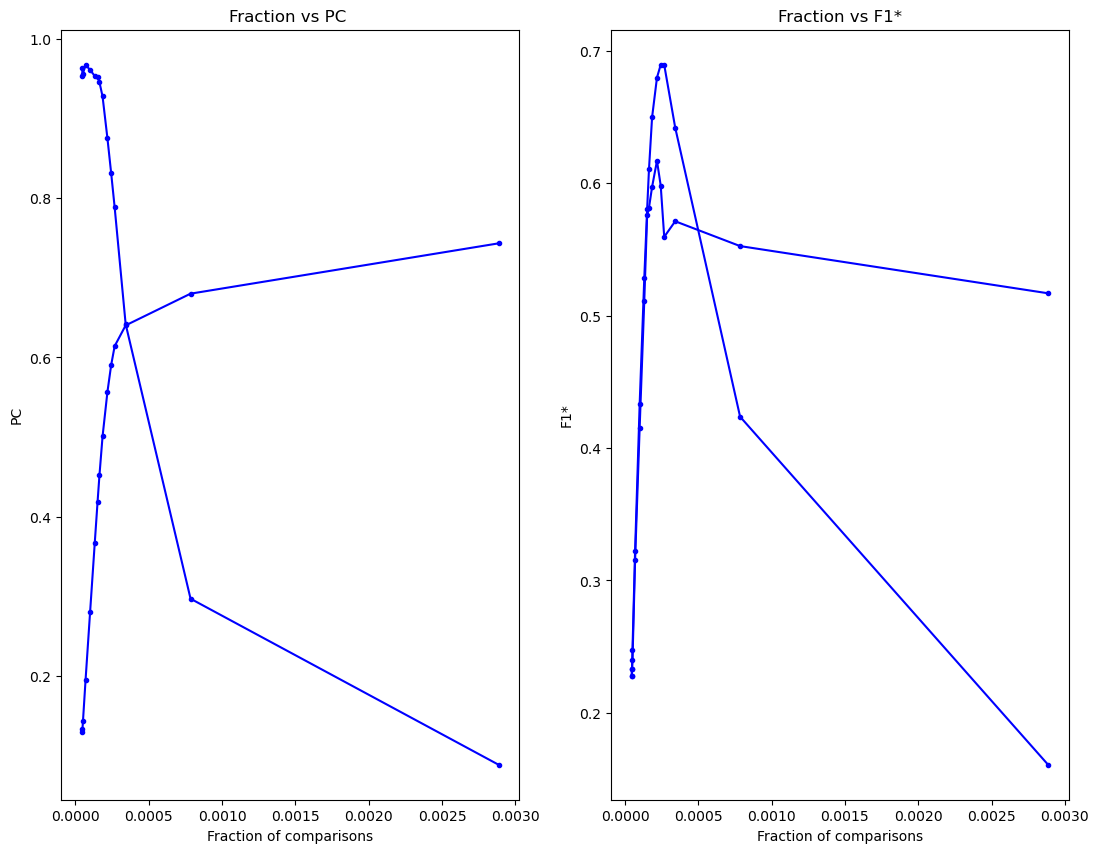

In [31]:
plt.figure(figsize = (13,10))
plt.subplot(221)
plt.plot(fraction, PQ_average , marker='.', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Fraction of comparisons')
plt.ylabel('PQ')
plt.title('Fraction vs PQ ')

# plt.subplot(222)
plt.plot(fraction, PC_average , marker='.', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Fraction of comparisons')
plt.ylabel('PC')
plt.title('Fraction vs PC ')

plt.subplot(223)
plt.plot(fraction, f1_average , marker='.', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Fraction of comparisons')
plt.ylabel('F1')
plt.title('Fraction vs F1 ')

plt.subplot(224)
plt.plot(fraction, f1_star_average , marker='.', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Fraction of comparisons')
plt.ylabel('F1*')
plt.title('Fraction vs F1*')

plt.show()

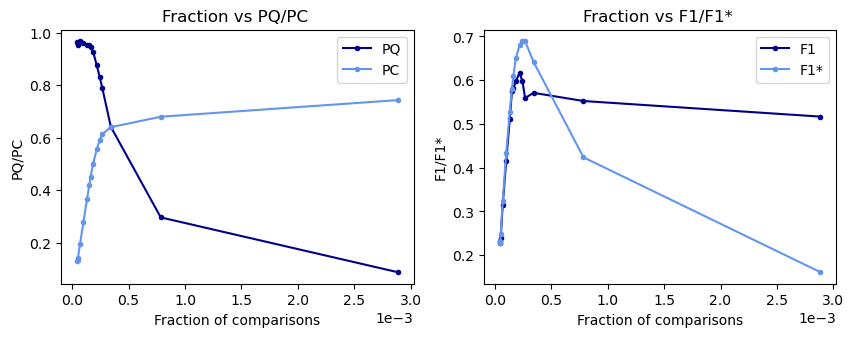

In [65]:
plt.figure(figsize = (10,3.3))
plt.subplot(121)
plt.plot(fraction, PQ_average , marker='.', linestyle='-', color='darkblue',label = 'PQ')
plt.plot(fraction, PC_average , marker='.', linestyle='-', color='cornflowerblue', label = 'PC')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

# Add labels and title
plt.xlabel('Fraction of comparisons')
plt.ylabel('PQ/PC')
plt.title('Fraction vs PQ/PC ')
plt.legend()

plt.subplot(122)
plt.plot(fraction, f1_average , marker='.', linestyle='-', color='darkblue', label = 'F1')
plt.plot(fraction, f1_star_average , marker='.', linestyle='-', color='cornflowerblue', label = 'F1*')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

# Add labels and title
plt.xlabel('Fraction of comparisons')
plt.ylabel('F1/F1*')
plt.title('Fraction vs F1/F1* ')
plt.legend()

plt.show()

In [3]:
print(PQ_average)
print(f1_star_average)

[0.08823529 0.29681979 0.64181524 0.78838174 0.83143508 0.87531807
 0.92792793 0.94576271 0.95220588 0.9535865  0.96111111 0.96774194
 0.95652174 0.95348837 0.96385542]
[0.1609632  0.42361378 0.64185471 0.68916931 0.68926927 0.67955947
 0.64965273 0.61065763 0.5802457  0.52839682 0.43306232 0.3226372
 0.24776566 0.23297239 0.22825115]


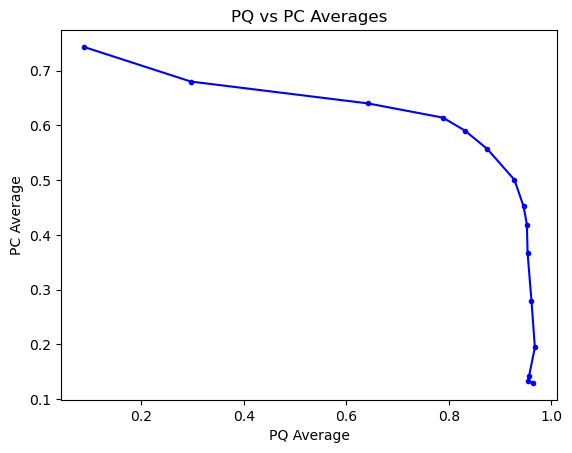

In [3]:
plt.plot(PQ_average, PC_average, marker='.', linestyle='-', color='b')

# Add labels and title
plt.xlabel('PQ Average')
plt.ylabel('PC Average')
plt.title('PQ vs PC Averages')
plt.show()

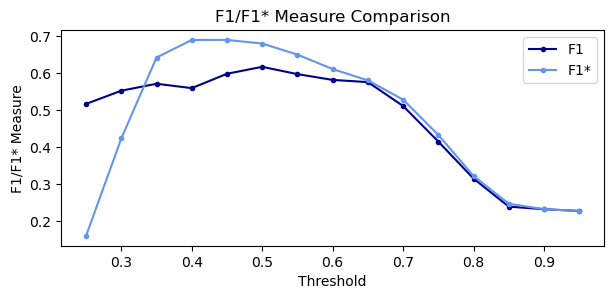

In [67]:
plt.figure(figsize = (7,2.8))
plt.plot(threshold, f1_average, label='F1', marker='.', linestyle='-', color = 'darkblue')
plt.plot(threshold, f1_star_average, label='F1*', marker='.', linestyle='-', color = 'cornflowerblue')

# plt.subplot(121)
# Add labels and title
plt.xlabel('Threshold')
plt.ylabel('F1/F1* Measure')
plt.title('F1/F1* Measure Comparison')
plt.legend()


# Show the plot
plt.show()

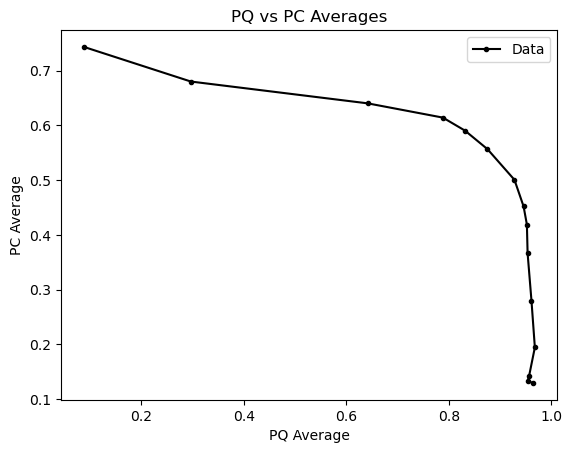

In [15]:
# Plot the data
plt.plot(PQ_average, PC_average, marker='.', linestyle='-', color='black', label='Data')

# Add labels and title
plt.xlabel('PQ Average')
plt.ylabel('PC Average')
plt.title('PQ vs PC Averages')

# Add a legend
plt.legend()

# # Save the plot as a PDF for high-quality export
# plt.savefig('plot_output.pdf', bbox_inches='tight')

# Show the plot
plt.show()

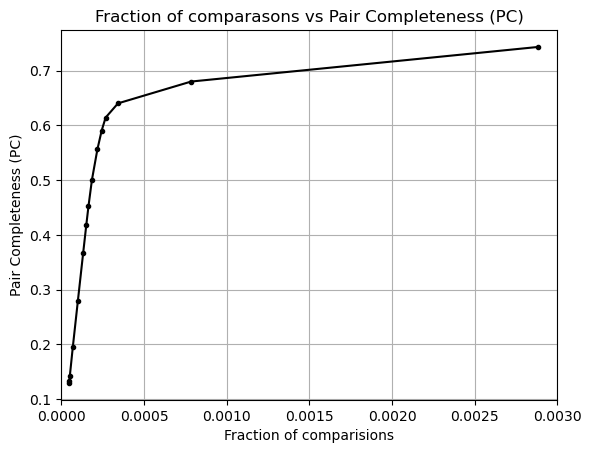

In [16]:
# Plotting

# Use LaTeX for scientific fonts

plt.plot(fraction,PC_average, marker='.', linestyle='-', color='black')
plt.xlabel('Fraction of comparisions')
plt.ylabel('Pair Completeness (PC)')
plt.title('Fraction of comparasons vs Pair Completeness (PC)')
plt.xlim(0,0.003)
plt.grid(True)
# plt.legend()
plt.show()

In [446]:
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
PQ_average